In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

vgsales = pd.read_csv("vgsales.csv")
vgsales = pd.DataFrame(vgsales)

vgsales['Year'] = vgsales['Year'].fillna(-1)
vgsales['Year'] = vgsales['Year'].astype(int)
vgsales.set_index('Rank', inplace=True, drop=True)
vgsales

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...
16596,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16597,Men in Black II: Alien Escape,GC,2003,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16598,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,Activision,0.00,0.00,0.00,0.00,0.01


# Objetivo do Trabalho

Meu objetivo nesse trabalho será avaliar a quantidade de vendas cumulativas de cada gênero específico de jogos ao longo dos anos. Para visualizar isso de uma forma prática e interessante, criarei uma chamada "bar chart race", um tipo de animação onde cada frame representa um ano específico, com o gráfico de barras representando a quantidade as vendas de cada gênero. Dessa forma, será possível analizar de forma mais direta os dados, a fim de descobrir se existe algum tipo de tendência no mercado de jogos em relação os gêneros mais populares com o passar do tempo. 

## Manipulação dos Dados

Entretanto, para montar uma visualização como essa, é primeiro preciso tratar a base de dados original. Como se pode ver na tabela a seguir, a quantidade de vendas retratada na tabela não são as vendas cumulativas até aquele ano, e sim as vendas específicas que ocorreram naquele ano. Além disso, há ainda diversos jogos cujo ano de lançamento não está disponível na base. Esses jogos serão descartados na análise que eu farei posteriormente.

In [205]:
vgsales[(vgsales["Year"] != -1)].groupby(["Year"],as_index=False)[["Global_Sales"]].sum().head()

,Year,Global_Sales
0,1980,11.38
1,1981,35.77
2,1982,28.86
3,1983,16.79
4,1984,50.36


Agora, farei uma série de operações para criar um novo dataframe, que contém as vendas cumulativas de cada gênero por ano. Para isso, criarei um subset do dataframe original através do comando .groupby, agrupando os dados pelo ano e gênero de cada jogo, e somando o valor de "Global_Sales" de cada combinação. Além disso, já definirei algumas variáveis que serão utilizadas posteriormente no processo.

In [206]:
vgsales_year = vgsales[(vgsales["Year"] != -1)].groupby(["Year", "Genre"],as_index=False)[["Global_Sales"]].sum()

genres = set()
years = []
cumulative = []
genreslist = []

vgsales_year.head()

,Year,Genre,Global_Sales
0,1980,Action,0.34
1,1980,Fighting,0.77
2,1980,Misc,2.71
3,1980,Shooter,7.07
4,1980,Sports,0.49


Com o subset e as variáveis auxiliares prontas, podemos começar as operações. Primeiramente, criarei um conjunto de todos os gêneros diferentes (a variável "genres"), e utilizarei dois conjuntos de for loops para "escanear" cada linha da tabela vgsales_year, e atribuir os valores de venda corretamente para cada ano e gênero distinto. Por último, criarei um dataframe com base nesses dados, que será utilizado para a animação seguinte.

In [207]:
for tupla in vgsales_year.itertuples():
    genres.add(tupla.Genre)


for genre in genres:
    sales = 0
    for tupla in vgsales_year.itertuples():
        if tupla.Genre == genre:
            years.append(tupla.Year)
            sales += tupla.Global_Sales
            cumulative.append(sales)
            genreslist.append(tupla.Genre)

dic = {"Year": years,
       "Cumulative_Sales": cumulative,
       "Genre": genreslist}

df = pd.DataFrame(dic)

df.head(35)

,Year,Cumulative_Sales,Genre
0,1980,2.71,Misc
1,1982,3.58,Misc
2,1983,5.72,Misc
3,1984,7.17,Misc
4,1989,8.45,Misc
5,1991,8.53,Misc
6,1992,13.47,Misc
7,1993,13.77,Misc
8,1994,16.63,Misc
9,1995,23.03,Misc


Como pode ser visto na tabela acima, as operações foram um sucesso!

In [208]:
genres

{'Action',
 'Adventure',
 'Fighting',
 'Misc',
 'Platform',
 'Puzzle',
 'Racing',
 'Role-Playing',
 'Shooter',
 'Simulation',
 'Sports',
 'Strategy'}

In [209]:
hex = ['#D2D8B3', '#C38D94', '#C3D350', '#A1E8AF',
     '#3C91E6', '#FE5F55', '#90DDF0', '#808F85',
     '#F4B942', '#6A994E', '#747C92', '#E086D3']
colors = dict(zip(genres, hex))
print(colors)

{'Misc': '#D2D8B3', 'Action': '#C38D94', 'Role-Playing': '#C3D350', 'Simulation': '#A1E8AF', 'Strategy': '#3C91E6', 'Fighting': '#FE5F55', 'Racing': '#90DDF0', 'Puzzle': '#808F85', 'Adventure': '#F4B942', 'Platform': '#6A994E', 'Shooter': '#747C92', 'Sports': '#E086D3'}


{'Misc': '#D2D8B3', 'Action': '#C38D94', 'Role-Playing': '#C3D350', 'Simulation': '#A1E8AF', 'Strategy': '#3C91E6', 'Fighting': '#FE5F55', 'Racing': '#90DDF0', 'Puzzle': '#808F85', 'Adventure': '#F4B942', 'Platform': '#6A994E', 'Shooter': '#747C92', 'Sports': '#E086D3'}


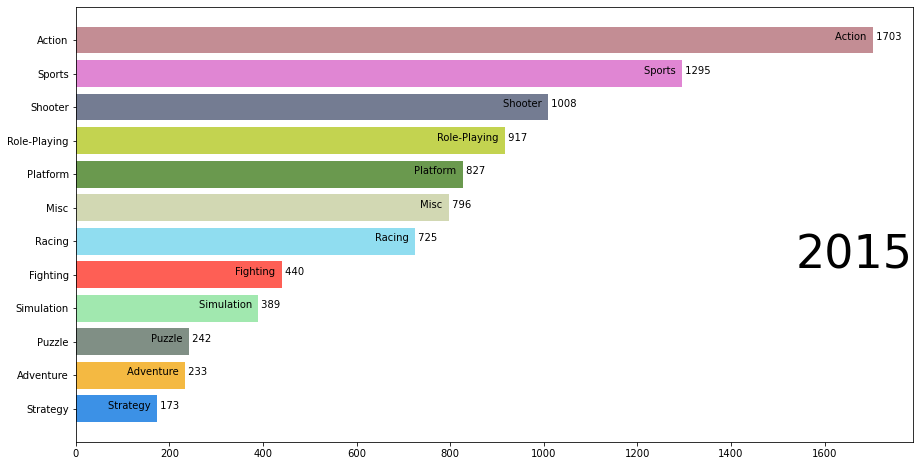

In [210]:
Current_Year = 2015
dff = (df[df["Year"].eq(Current_Year)]
        .sort_values(by="Cumulative_Sales", ascending=True))


fig, ax = plt.subplots(figsize = (15, 8))

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

ax.barh(dff["Genre"], dff["Cumulative_Sales"], color = [colors[x] for x in dff["Genre"]])

for i, (sales, genre) in enumerate(zip(dff["Cumulative_Sales"], dff["Genre"])):
        ax.text(sales, i,       genre + "  ",          ha="right")
        ax.text(sales, i,       " " + str(round(sales)),          ha="left")

ax.text(1, 0.4, Current_Year, transform=ax.transAxes, size=46, ha="right")

print(colors)
